In [2]:
import numpy as np
import pandas as pd
import math

import src.hdmm.workload as workload
import src.census_workloads as census
from src.workload_selection import workload_selection
import online_workloads as online_workloads

In [327]:
def pmw_naive(workload, x, analyst_labels, T, eps=0.01, total_k=None, 
         show_messages=False, to_return='error', show_plot=False, show_failure_step=False, eta = None):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries where analysts can run out of privacy budget if they use too much of others'. 
    
    In other words, all analysts share from the same privacy budget. 
    
    Last Updated: 4-10-2022

    Algorithm Parameters: 
    - workload = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    - T = update threshold
    - eps = privacy budget
    - total_k = total number of update steps alloted for the entire group
    - analyst_labels = list of analyst names corresponding to each query in the workload
    
    Output Controls: 
    - show_messages argument determines whether the function will print information such as 
    error scale, threshold, update steps used, etc.
    - to_return argument determines what the function will return. 
        - if 'pd', pmw() returns pandas df with test data for each 
        query in the workload(showing query, d_t_hat, updated, algo_ans, real_ans, 
        abs_error, rel_error). 
        - if 'update_count', pmw() returns the update count for the total
        amount of queries.
    - show_plot - T/F whether the function will display a plot
    - show_failure_step - T/F whether function prints what step failure mode is reached
    """ 
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()
    if(eta == None):
        eta = (math.log(m, np.e) / ((math.sqrt(n))) )
    print(eta)
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    
    # initialize synthetic databases at time 0 (prior to any queries)
    x_t = np.ones(m) / m
    y_t = np.ones(m) / m

    # initialize tracker lists to construct pandas dataframe at the end 
    x_list = [x_t] # create a list of x_t synthetic database at every time step
    update_list = []
    update_count = 0
    pmw_answers = []
    update_times = [] # record times that database is updated
    d_t_hat_list = []
    
    # initialize total_k, the total number of update steps if not default
    if total_k == None:
        total_k = round(n * math.log(math.sqrt(m)) / 770) #770
        print(f'{total_k=}')
    
    def lazy_round():
        """
        "Lazy Round" of querying using the stored synthetic database, x_t, in list x_list.
        
        We call this the lazy round because it is contrasted with the updated step where we update the 
        sythetic database and answer the query using the real database.
        """
        update_list.append('no')
        answer = np.dot(query, x_list[time])
        if answer < 0:
            pmw_answers.append(0)
        else: 
            pmw_answers.append(answer)
        x_list.append(x_list[time])
    
    # inititate first instance of SVT with half the budget and k updates; will be reset in the main loop
    SVTtrigger = False 
    SVTepsilon1 = ((eps/2)/2)
    SVTepsilon2 = ((eps/2)/2)
    rho = np.random.laplace(loc=0, scale=(1/SVTepsilon1), size=1)[0]
    #print(rho + T)
    
    
    for time, query in enumerate(workload):
        
        analyst = analyst_labels[time]
        
        # Do one round of sparse vector technique; compute noisy answer by adding Laplacian noise
        A_t = np.random.laplace(loc=0, scale=(total_k/SVTepsilon2), size=1)[0]
        a_t_hat = (np.dot(query, x_norm)*n ) + A_t
        d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
        
        # LAZY ROUND: QUERY USING THE SYNTHETIC DATABASE
        if (abs(d_t_hat) <= T + rho):
            d_t_hat_list.append(d_t_hat)
            lazy_round()

        # UPDATE ROUND: UPDATE SYNTHETIC DATABASE AND RETURN NOISY ANSWER, A_T-HAT
        else:
            # noise
            A_t = np.random.laplace(loc=0, scale=(2*total_k/eps), size=1)[0]
            
            # noisy answer
            a_t_hat = (np.dot(query, x_norm)*n ) + A_t
            d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
            d_t_hat_list.append(d_t_hat)
            update_times.append(time)
            
            # step a
            if d_t_hat < 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i in range(len(y_t)):
                y_t[i] = x_list[time][i] * math.exp(-( eta * r_t[i]))# eta is the learning rate
            
            # step b
            x_t = y_t / np.sum(y_t)
            update_count = update_list.count('yes')
            
            # if threshold for num updates is reached, just do a lazy round (synthetic database) answer
            if total_k == 0: 
                if show_failure_step:
                    print(f'Failure mode reached at query number {time}: {query}')
                lazy_round()
                
            # if there are still update steps that the analyst can use, 
            # 1. update the synthetic database
            # 2. answer the query using the noisy answer from the database itself 
            else: 
                x_list.append(x_t)
                update_list.append('yes') # increment number of updates counter
                answer = a_t_hat / np.sum(x)
                
                if answer < 0:
                    pmw_answers.append(0)
                else: 
                    pmw_answers.append(answer)
                
                total_k -= 1 # use one of the total update steps
        
        #print(f'{x_list[time] - x_list[time - 1]=}')
        
        
    update_count = update_list.count('yes')      

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(pmw_answers - real_ans)
    rel_error = np.abs(abs_error / np.where(real_ans == 0, 0.000001,
                                                real_ans))
    
    if show_messages:
        np.set_printoptions(suppress=True)
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Synthetic Database (after) = {x_list[len(x_list) - 1] * sum(x)}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Synthetic Database (before) = {x_list[0]}\n')
        print(f'Synthetic Database (after, norm) = {x_list[len(x_list) - 1]}\n')
        print(f'Difference btw. Final Synthetic and true database = {x_list[len(x_list) - 1] - x_norm}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{T=}\n')
        print(f'Error Scale Query Answer= {2*((2*total_k/eps)**2)}\n')
        print(f'Error Scale SVT= {2*((2*total_k/SVTepsilon2)**2)}\n')
        print(f'Update Parameter Scale = {eta}\n')
        print(f'{delta=}\n')
        
    if show_plot: 
        plt.title('Error across queries:')
        rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[abs_line,rel_line])
        plt.xticks(range(0, len(workload), round(len(workload)/5)))
    
    if to_return == "pd":
        # hacky fix: remove the first synthetic database to keep length of lists consistent with the
        # other lists that comprise of the pandas dataframe
        x_list.pop(0).tolist() 
        d = {
            'algo_ans': pmw_answers,
            'real_ans': real_ans.tolist(),
            'queries': workload.tolist(), 
            'updated': update_list,
            'abs_error': abs_error,               
            'rel_error': rel_error,
            'synthetic database': x_list,
            'analyst': analyst_labels,
            'd_t_hat': d_t_hat_list, 

             }
        test_data = pd.DataFrame(data=d)
        #test_data = test_data.round(3)
        return test_data
    
    if to_return == "error":
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,               
             'rel_error': rel_error,}
        data = pd.DataFrame(data=d)
        data = data.round(3)
        
        analyst_error = {}
        for analyst in list(sorted(analyst_labels)):
            analyst_error[analyst] = data[data.analyst==analyst]['abs_error'].sum()
        return analyst_error
    
    if to_return == "tse":
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,}
        data = pd.DataFrame(data=d)
        data['squared_err'] = data['abs_error'] ** 2
        
        analyst_error = {}
        for analyst in list(sorted(analyst_labels)):
            analyst_error[analyst] = data[data.analyst==analyst]['abs_error'].sum()
        return analyst_error

In [11]:
tenq = np.vstack((online_workloads.identity(5), online_workloads.identity(5)))
fiftyq = np.vstack((tenq, 
                   tenq, 
                   tenq, 
                   tenq, 
                   tenq))

In [12]:
# initialize databases

import pandas as pd
data_path = "migration_tworace.csv"
x_race = pd.read_csv(data_path, header=None).iloc[:, 1].to_numpy()
n = x_race.shape[0]
x_race

x_example = np.array([1000, 2000, 3000, 4000, 5000])
new_x = np.array([.1, .15, .2, .25, .3]) * 1500

In [7]:
ten_identity_q = np.vstack((online_workloads.identity(10), 
                            online_workloads.identity(10),
                            online_workloads.identity(10),
                            online_workloads.identity(10),
                            online_workloads.identity(10),
                            online_workloads.identity(10),
                            online_workloads.identity(10),
                            online_workloads.identity(10),
                            online_workloads.identity(10),
                            online_workloads.identity(10)))

hundred_identity_q = np.vstack((ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q))

print(f'{ten_identity_q.shape=}')
print(f'{hundred_identity_q.shape=}')

ten_identity_q.shape=(100, 10)
hundred_identity_q.shape=(1000, 10)


In [314]:
x_race_first_ten = x_race[:10]

# try identity on the race database
data = pmw_naive(hundred_identity_q, x_race_first_ten, ['A'] * 1000, eps=10, T=40, total_k = 100, 
          show_messages=True, to_return = 'pd')#to_return='tse')
data
data['abs_error'].sum() / len(data)

Original database: [412 333 285 231 202 174 160 142 146 149]

Normalized database: [0.18442256 0.14905998 0.12757386 0.10340197 0.09042077 0.0778872
 0.07162041 0.06356312 0.06535363 0.06669651]

Synthetic Database (before) = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

Synthetic Database (after) = [0.182 0.154 0.118 0.097 0.09  0.078 0.076 0.07  0.065 0.072]

Difference btw. Final Synthetic and true database = [-0.00242256  0.00494002 -0.00957386 -0.00640197 -0.00042077  0.0001128
  0.00437959  0.00643688 -0.00035363  0.00530349]

Update Count = 84

T=40

Error Scale Query Answer= 20.480000000000004

Error Scale SVT= 327.68000000000006

Update Parameter Scale = 0.048716278470739886

delta=5.8046389258630686e-05



0.004725326648749096

In [322]:
n=64
W_name = ['identity', 'total', 'H2', 'race1', 'race2', 'race3', 'custom', 'prefix_sum']
W_lst = [online_workloads.identity(n), online_workloads.total(n), online_workloads.H2(n), online_workloads.race1(), online_workloads.race2(), online_workloads.race3(), online_workloads.custom(n), online_workloads.prefix_sum(n)]

c = np.random.randint(len(W_lst))
final_W = W_lst[c] 

t = 10
for i in range(t): 
    c = np.random.randint(len(W_lst))
    print(c)
    final_W = np.vstack((final_W, W_lst[c]))
    
print(len(final_W))

final_W

5
5
1
4
0
5
4
3
0
7
350


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [350]:
data = pmw_naive(final_W, x_race[:64], ['A'] * len(final_W), eps=1, T=40, total_k = 1000, 
          show_messages=True, to_return='pd')
data

0.029045482601565774
Original database: [412 333 285 231 202 174 160 142 146 149 145 181 174 190 213 287 372 499
 619 715 785 821 822 816 799 742 717 697 658 593 564 519 447 403 388 365
 336 306 311 289 261 231 213 196 194 170 175 168 149 142 131 119 112 118
 114 116 112 114 106 111 109 112 113 109]

Synthetic Database (after) = [331.09575916 350.89905915 394.12989265 361.24055145 371.88682218
 382.84685359 394.12989265 382.84685359 350.89905915 382.84685359
 417.70335224 430.01366168 371.88682218 430.01366168 442.68677338
 382.84685359 442.68677338 482.99142986 497.22587143 482.99142986
 497.22587143 482.99142986 417.70335224 455.73337964 394.12989265
 430.01366168 442.68677338 340.85362016 417.70335224 321.61724344
 350.89905915 361.24055145 371.88682218 321.61724344 331.09575916
 303.46648872 312.41007598 321.61724344 278.14282493 240.54503495
 294.77893594 254.93236959 278.14282493 226.9696623  278.14282493
 226.9696623  220.47203902 226.9696623  262.44558763 240.54503495
 220.4720

,algo_ans,real_ans,queries,updated,abs_error,rel_error,synthetic database,analyst,d_t_hat
0,0.204913,0.016242,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.188670,11.615975,"[0.015617808141753755, 0.016078087069513525, 0...",A,3880.775837
1,0.078834,0.013901,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.064933,4.671057,"[0.015610622900983228, 0.016070690069519965, 0...",A,1296.054859
2,0.096603,0.009853,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.086750,8.804730,"[0.015603444268559172, 0.016063299872630207, 0...",A,1660.506499
3,0.043089,0.007121,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",yes,0.035968,5.050741,"[0.015596272235369118, 0.016055916469463225, 0...",A,563.506337
4,0.040272,0.018145,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.022128,1.219523,"[0.015589106792317352, 0.016048539850655245, 0...",A,505.907630
...,...,...,...,...,...,...,...,...,...
345,1.309136,0.978392,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",yes,0.330744,0.338048,"[0.01614108834452638, 0.017106509392107637, 0....",A,7057.664862
346,0.990507,0.983709,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",yes,0.006798,0.006911,"[0.01615315636346626, 0.017119299216122767, 0....",A,340.422564
347,0.895311,0.989172,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",yes,0.093861,0.094888,"[0.01614526163642135, 0.017110932294422124, 0....",A,-1806.172380
348,1.050634,0.994683,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",yes,0.055950,0.056249,"[0.01614943708689064, 0.017115357484418274, 0....",A,1223.255086


In [359]:
final_synthdb = data.iloc[len(data) - 1, 6]

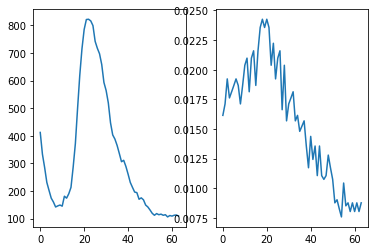

In [362]:
import matplotlib.pyplot as plt


x1 = range(64)
y1 = x_race[:64]

x2 = range(64)
y2 = final_synthdb

plt.subplot(1, 2, 1)
plt.plot(x1, y1)
#plt.title('A tale of 2 subplots')
#plt.ylabel('Damped oscillation')


plt.subplot(1, 2, 2)
plt.plot(x2, y2)
#plt.xlabel('time (s)')
#plt.ylabel('Undamped')

plt.show()

#plt.plot(x1, y1, color ="red")

In [367]:
w = np.array([[1, 2, 3],
             [4, 5, 6],
             [7, 8, 9]])
w[0]

array([1, 2, 3])

In [393]:
p = 0.5

if np.random.random()<p:
    print('dog')

dog


In [409]:
a_ex = np.array([[1, 2, 3],
             [4, 5, 6],
             [7, 8, 9]])

b_ex = np.array([[11, 22, 33],
             [44, 55, 66],
             [77, 88, 99]])

b_bad = np.array([[1, 1, 1, 1]])

skewed_scheduler(0.5, a_ex, b_bad)

TypeError: a and b dimensions don't match

In [414]:
a_ex[1:]

array([[4, 5, 6],
       [7, 8, 9]])

In [405]:
from typing import Tuple

In [531]:
def skewed_scheduler(p: int, a: np.ndarray, b: np.ndarray) -> Tuple: 
    """
    Schedules Alice's queries with a probability of p and Bob's queries with a probability of (p - 1).
    
    Returns new workload of queries (2x2 np.array) and analyst labels (python list). 
    
    p: prob of scheduling Alice's queries
    a: alice's workload
    b: bob's workload
    """
    
    W = []
    analyst_labels = []
    
    if a.shape[1] != b.shape[1]:
         raise TypeError("a and b dimensions don't match")
    
    a_pointer = 0
    b_pointer = 0
    
    while(a_pointer < len(a) and b_pointer < len(b)):
        if np.random.random() < p:
            W.append(a[a_pointer])
            a_pointer += 1
            analyst_labels.append('A')
        else: 
            W.append(b[b_pointer])
            b_pointer += 1
            analyst_labels.append('B')
            
    print(W)
    print(a_pointer, b_pointer)
    
    if a_pointer == len(a):
        W = np.vstack((W, b[b_pointer:]))
        analyst_labels += ['B' for i in range(b_pointer, len(b))]
    if b_pointer == len(b): 
        W = np.vstack((W, a[a_pointer:]))
        analyst_labels += ['A' for i in range(a_pointer, len(a))]
    
    W = np.array(W)
    return W, analyst_labels
    
skewed_scheduler(0.5, a_ex, b_ex)

[array([11, 22, 33]), array([44, 55, 66]), array([1, 2, 3]), array([4, 5, 6]), array([77, 88, 99])]
2 3


(array([[11, 22, 33],
        [44, 55, 66],
        [ 1,  2,  3],
        [ 4,  5,  6],
        [77, 88, 99],
        [ 7,  8,  9]]),
 ['B', 'B', 'A', 'A', 'B', 'A'])